# 实验三：参数估计 & 非参数估计
- 姓名：冯思程
- 学号：2112213
- 专业：计算机科学与技术

## 实验要求
### 截止日期：11月3日
作业的提交格式参考之前的说明，提交到18329300691@163.com
### 基本要求
生成两个各包含 N=1000 个二维随机向量的数据集合 $X_1$ 和 $X_2$，数据集合中随机向量来自于三个分布模型，分别满足均值向量 $\mu_1=[1,4]$,$\mu_2=[4,1]$, $\mu_3=[8,4]$ 和协方差矩阵 $D_1=D_2=D_3=2\pmb{I}$ ，其中$\pmb{I}$是 $2*2$的单位矩阵。在生成数据集合 $X_1$ 时，假设来自三个分布模型的先验概率相同 ；而在生成数据集合 $X_2$ 时，先验概率如下：$p(w_1)=0.6$, $p(w_2)=0.3$, $p(w_3)=0.1$


<img src="https://i.loli.net/2021/03/31/7WT8naYPQc9N56x.png" alt="image.png" style="zoom: 40%;" /> 
<img src="https://i.loli.net/2021/03/31/qsetFODzM7IhYaN.png" alt="image.png" style="zoom:40%;" />

在两个数据集合上分别应用“似然率测试规则” 和“最大后验概率规则” 进行分类实验，计算分类错误率，分析实验结果。


### 中级要求
在两个数据集合上使⽤⾼斯核函数估计⽅法，应⽤“似然率测试规则”分类和“最大后验概率规则”在 [0.1, 0.5, 1, 
1.5, 2] 范围内交叉验证找到最优 h 值，分析实验结果

### 高级要求
在两个数据集合上使⽤进⾏k-近邻概率密度估计，计算并分析 k=1，3，5 时的概率密度估计
结果

=======================================================================================================================

# 开始

**环境**：python 3.10.9+vscode 1.82.2+一些必备的第三方库，例如numpy、pandas等。

<span style="color:red">**注意**</span>：我在后文的代码都补充了详细的注释并在代码前进行了适当注释和分析，感谢学长学姐的批阅！辛苦！

## 基础要求部分

### 导入需要的包

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 数据生成

In [16]:


# 设置参数，个数、均值向量、协方差矩阵
N = 1000
mu1 = np.array([1, 4])
mu2 = np.array([4, 1])
mu3 = np.array([8, 4])
cmatrix = 2 * np.identity(2)

# 生成X1数据集，三个分布模型的先验概率相同
n_per_class = N // 3  
x1_1 = np.random.multivariate_normal(mu1, cmatrix, n_per_class)
x1_2 = np.random.multivariate_normal(mu2, cmatrix, n_per_class)
x1_3 = np.random.multivariate_normal(mu3, cmatrix, N - 2*n_per_class)

X1 = np.vstack((x1_1, x1_2, x1_3))

# 生成X2数据集
x2_1 = np.random.multivariate_normal(mu1, cmatrix, int(0.6 * N))
x2_2 = np.random.multivariate_normal(mu2, cmatrix, int(0.3 * N))
x2_3 = np.random.multivariate_normal(mu3, cmatrix, N - int(0.6 * N) - int(0.3 * N))

X2 = np.vstack((x2_1, x2_2, x2_3))

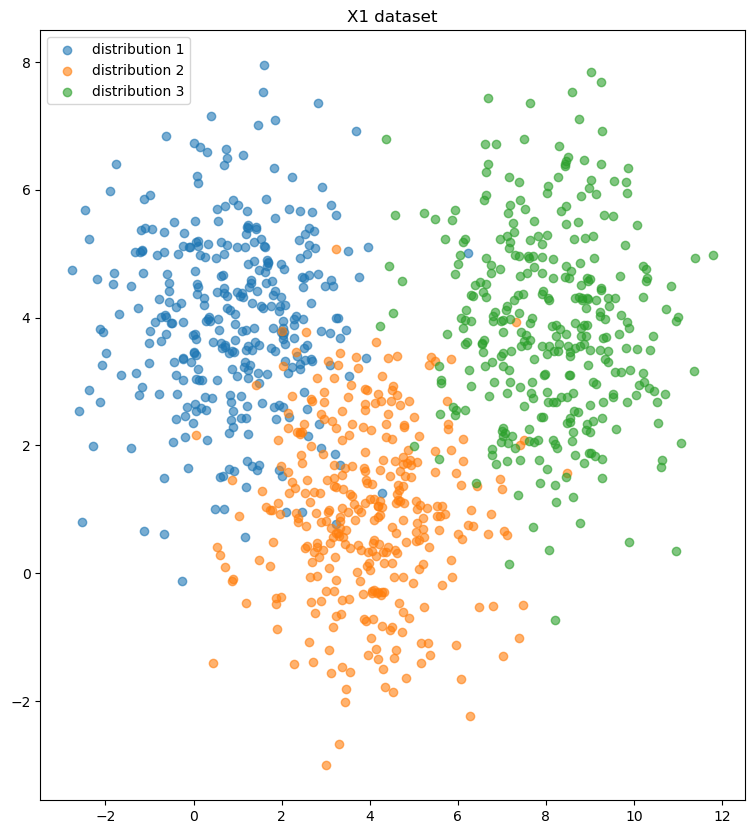

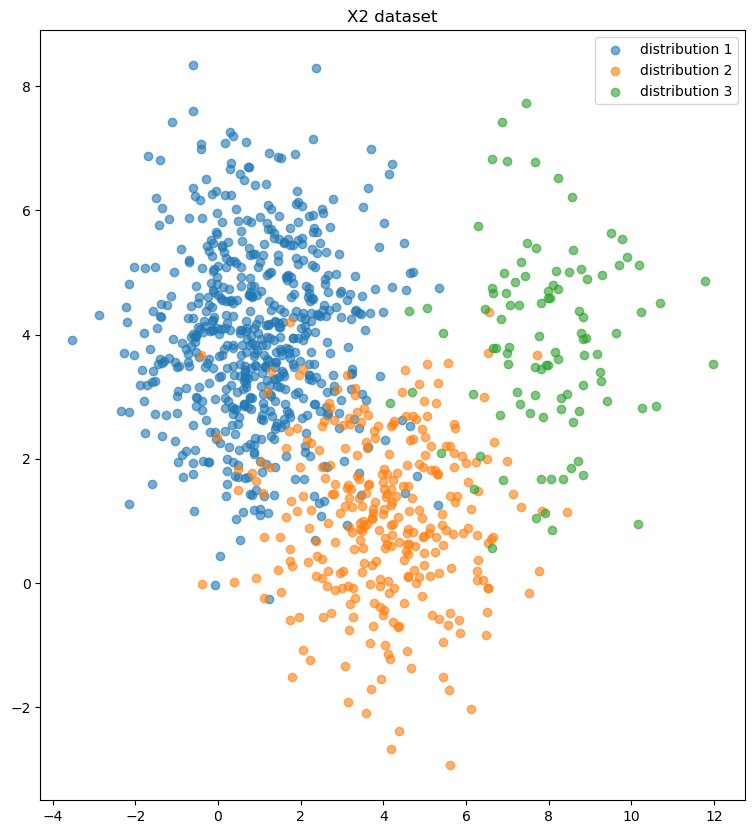

In [17]:

# 将数据进行可视化一下
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.figure(figsize=(20, 10))
# X1的可视化
plt.subplot(1, 2, 1)
plt.scatter(x1_1[:, 0], x1_1[:, 1], label="distribution 1", alpha=0.6)
plt.scatter(x1_2[:, 0], x1_2[:, 1], label="distribution 2", alpha=0.6)
plt.scatter(x1_3[:, 0], x1_3[:, 1], label="distribution 3", alpha=0.6)
plt.title("X1 dataset")
plt.legend()


# X2的可视化
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(x2_1[:, 0], x2_1[:, 1], label="distribution 1", alpha=0.6)
plt.scatter(x2_2[:, 0], x2_2[:, 1], label="distribution 2", alpha=0.6)
plt.scatter(x2_3[:, 0], x2_3[:, 1], label="distribution 3", alpha=0.6)
plt.title("X2 dataset")
plt.legend()
plt.show()


### 应用似然率测试规则

这里应用的方法就是最大似然估计，对于多元高斯分布，概率密度函数为:


$ p(\mathbf{x} | \mu, \Sigma) = \frac{1}{(2\pi)^{p/2}|\Sigma|^{1/2}} \exp\left(-\frac{1}{2}(\mathbf{x}-\mu)^T\Sigma^{-1}(\mathbf{x}-\mu)\right) $


我根据上述公式来计算给定数据点属于某个类的似然度。

In [18]:
#计算某数据点属于某个类的似然度函数
def gauss(x,average,matrix):
    p=len(average)
    matrix_inv = np.linalg.inv(matrix)
    matrix_det = np.linalg.det(matrix)
    normalization_term = 1 / (np.power(2*np.pi, p/2) * np.sqrt(matrix_det))
    exponent = -0.5 * np.dot((x-average).T, np.dot(matrix_inv, (x-average)))
    return normalization_term * np.exp(exponent)


#定义一个函数来进行预测
def predict(X, averages, matrix):
    predictions = []
    for x in X:
        likelihoods = [gauss(x, average, matrix) for average in averages]
        predicted_label = np.argmax(likelihoods)
        predictions.append(predicted_label)
    return np.array(predictions)

In [19]:
# 预测
y1_pred = predict(X1, [mu1, mu2, mu3], cmatrix)
y2_pred = predict(X2, [mu1, mu2, mu3], cmatrix)

# 为X1数据集中每一类生成标签
y1_1 = np.full((n_per_class,), 0) 
y1_2 = np.full((n_per_class,), 1) 
y1_3 = np.full((N - 2*n_per_class), 2)
y1 = np.concatenate((y1_1, y1_2, y1_3))
# 为X2数据集中每一类生成标签
y2_1 = np.full((int(0.6 * N),), 0)
y2_2 = np.full((int(0.3 * N),), 1)
y2_3 = np.full((N - int(0.6 * N) - int(0.3 * N)), 2)
y2 = np.concatenate((y2_1, y2_2, y2_3))

# 计算错误率
error_rate_X1 = np.mean(y1_pred != y1)
error_rate_X2 = np.mean(y2_pred != y2)
print(f"使用最大似然估计的错误率 (X1): {error_rate_X1 * 100:.3f}%")
print(f"使用最大似然估计的错误率 (X2): {error_rate_X2 * 100:.3f}%")

使用最大似然估计的错误率 (X1): 5.600%
使用最大似然估计的错误率 (X2): 8.100%


### 应用最大后验概率规则

这里应用的方法是MAP：

<img src="https://s2.loli.net/2022/10/20/LqxEFgKtNwl9ZG5.png" alt="image.png" style="zoom:50%"/>


In [20]:
# 定义map预测函数
def mappredict(X, averages, matrix, priors):
    predictions = []
    for x in X:
        posterior_probs = [gauss(x, average, matrix) * prior for average, prior in zip(averages, priors)]
        predicted_label = np.argmax(posterior_probs)
        predictions.append(predicted_label)
    return np.array(predictions)

In [21]:
# 这里X1的先验概率进行了一个小近似，实际上由于1000不能被3整除，先验概率实际上变成了333：333：334
priors_X1 = [1/3, 1/3, 1/3] 
priors_X2 = [0.6, 0.3, 0.1] 

# 使用MAP规则对X1和X2进行分类
y1_pred_map = mappredict(X1, [mu1, mu2, mu3], cmatrix, priors_X1)
y2_pred_map = mappredict(X2, [mu1, mu2, mu3], cmatrix, priors_X2)

# 计算错误率
error_rate_X1_map = np.mean(y1_pred_map != y1)
error_rate_X2_map = np.mean(y2_pred_map != y2)

print(f"使用MAP的错误率 (X1): {error_rate_X1_map * 100:.3f}%")
print(f"使用MAP的错误率 (X2): {error_rate_X2_map * 100:.3f}%")

使用MAP的错误率 (X1): 5.600%
使用MAP的错误率 (X2): 7.400%


#### 分析

- 首先注意到对于X1数据集，由于其中的三类是均衡的，所以会发现无论是用似然率规则还是最大后验概率都是相同的结果，这里在所用的公式就可以有所体现，当最大后验规则应用的数据集的先验概率是均衡的时候，其结果和应用似然率规则应该完全一致。同理，如果当先验概率差别不大的时候，这两个规则的结果应该是相近的。
- 对于X2数据集来说，我经过多次测试，发现一般来说最大后验概率规则下的分类错误率要比极大似然规则概率下的分类错误率更小。这表明通过结合先验信息可以改善分类的准确性。尤其是对于那些样本数据类别组成十分不均衡的数据集来说。

## 中级要求部分

这里我们开始进行非参数估计，推导过程如下：

- 在⾮参数估计中，假定相似的输⼊具有相似的输出，不对基础密度假定任何形式的先验参数
- ⾮参数模型的复杂性依赖于训练集的⼤⼩，依赖于数据中问题的固有复杂性
- 当给定训练集时，并不计算模型，⽽将模型的计算推迟到给定⼀个检验实例时才进⾏，这会导致存储和计算量的增加。(⽐如：开卷考试)
- 核⼼思路：⼀个向量 落⼊区间 $R$ 中的概率为 $ p=\int_{R} p(x) d x $
- 主要⽅法：直⽅图估计、核估计、k最近邻估计
<img src="https://s2.loli.net/2022/10/20/5vkSjX9TRCdsEKp.png" alt="image.png" style="zoom:100%"/>
- 当样本数 $ \mathrm{n} $ 足够大时, 可以近似地认为 $ P \approx \frac{k}{n} $ , 其中 $ \mathrm{k} $ 是出现该特征的频数。
- 假设密度函数 $ p(x) $ 是连续的, 那么在区域 $ R $ 足够小时, 我们可以近似地认为 $ p(x) $ 是一个常值函数, 因此 $ P \approx p(x) V $, 其中  $V $ 是区域 $ R $ 的体积。
$$ \frac{k}{n} \approx P \approx p(x) V \Rightarrow p(x) \cong \frac{k}{n V}$$



<img src="https://s2.loli.net/2022/10/20/eiRhoIztdyHNXuk.png" style="zoom:50%"/>

本次实验用到的高斯核函数就是下图中右下位置的那个函数：

<img src="https://s2.loli.net/2022/10/20/AHkVMFi3v8LpYqb.png"  style="zoom:50%"/>

然后知道h选择的重要性，利用交叉验证找到每个规则下的最佳h

<img src="https://s2.loli.net/2022/10/20/9hAui8l6KYycsLH.png"  style="zoom:50%"/>


### Gauss核函数+似然率测试规则


In [22]:
# 计算某数据点的高斯核值
def gausskernel(x, data, h):
    diff = x - data
    exponent = - (np.linalg.norm(diff, axis=1) ** 2) / (2 * h ** 2)
    return np.sum((1 / (np.sqrt(2 * np.pi) * h)) * np.exp(exponent)) / len(data)
# 定义分类函数，这里面datasets是需要将整个数据集按照类别划分开的结果
def classifymle(x, datasets, h):
    likelihoods = [gausskernel(x, dataset, h) for dataset in datasets]
    return np.argmax(likelihoods)
# 用来按类别划分大数据集的
def split_data_by_labels(X, y, num_classes=3):
    datasets = [X[y == i] for i in range(num_classes)]
    return datasets

#### 交叉验证

我这里采用了10折交叉验证的方法对平均错误率进行评估，然后据此找到最佳h，这个我经过原来的测试发现经常会出现2是最佳h的情况，这让我考虑是不是给出的h范围有一些窄，于是我自动将h的范围进行了适当的扩充，这并不会导致计算速度明显拖慢，扩宽后的h范围是：[0.1, 0.5, 1, 1.5, 2,2.5,3,3.5,4]

In [23]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=42)  # 10折交叉验证
hs = [0.1, 0.5, 1, 1.5, 2,2.5,3,3.5,4]

# X1数据集
errors = {h: [] for h in hs}

for train_index, test_index in kf.split(X1):
    X1_train, X1_test = X1[train_index], X1[test_index]
    y1_train, y1_test = y1[train_index], y1[test_index]

    datasets_X1_train = split_data_by_labels(X1_train, y1_train)

    for h in hs:
        X1predicted_labels = [classifymle(x, datasets_X1_train, h=h) for x in X1_test]
        error_rate = np.mean(np.array(X1predicted_labels) != y1_test)
        errors[h].append(error_rate)

# 计算平均错误率并找到最佳h值
avg_errors = {h: np.mean(errors[h]) for h in hs}
best_h = min(avg_errors, key=avg_errors.get)

print(f"采用Gauss核函数+似然率测试规则，X1数据集下最佳h值为 {best_h}，对应的平均错误率为: {avg_errors[best_h] * 100:.3f}%")

# X2数据集
errors_X2 = {h: [] for h in hs}
for train_index, test_index in kf.split(X2):
    X2_train, X2_test = X2[train_index], X2[test_index]
    y2_train, y2_test = y2[train_index], y2[test_index]

    datasets_X2_train = split_data_by_labels(X2_train, y2_train)

    for h in hs:
        X2predicted_labels = [classifymle(x, datasets_X2_train, h=h) for x in X2_test]
        error_rate = np.mean(np.array(X2predicted_labels) != y2_test)
        errors_X2[h].append(error_rate)
avg_errors_X2 = {h: np.mean(errors_X2[h]) for h in hs}
best_h_X2 = min(avg_errors_X2, key=avg_errors_X2.get)

print(f"采用Gauss核函数+似然率测试规则，X2数据集下最佳h值为 {best_h_X2}，对应的平均错误率为: {avg_errors_X2[best_h_X2] * 100:.3f}%")

采用Gauss核函数+似然率测试规则，X1数据集下最佳h值为 1，对应的平均错误率为: 5.100%
采用Gauss核函数+似然率测试规则，X2数据集下最佳h值为 3.5，对应的平均错误率为: 8.200%


### Gauss核函数+最大后验概率规则

In [24]:
# 定义分类函数，这里面datasets是需要将整个数据集按照类别划分开的结果，这里需要假入先验概率
def classifymap(x, datasets, h, priors):
    likelihoods = [gausskernel(x, dataset, h) for dataset in datasets]
    posteriors = [lik * prior for lik, prior in zip(likelihoods, priors)]
    return np.argmax(posteriors)

In [25]:
# X1数据集
errors = {h: [] for h in hs}

for train_index, test_index in kf.split(X1):
    X1_train, X1_test = X1[train_index], X1[test_index]
    y1_train, y1_test = y1[train_index], y1[test_index]

    datasets_X1_train = split_data_by_labels(X1_train, y1_train)

    for h in hs:
        X1predicted_labels = [classifymap(x, datasets_X1_train, h,priors_X1) for x in X1_test]
        error_rate = np.mean(np.array(X1predicted_labels) != y1_test)
        errors[h].append(error_rate)

# 计算平均错误率并找到最佳h值
avg_errors = {h: np.mean(errors[h]) for h in hs}
best_h = min(avg_errors, key=avg_errors.get)

print(f"采用Gauss核函数+最大后验概率规则，X1数据集下最佳h值为 {best_h}，对应的平均错误率为: {avg_errors[best_h] * 100:.3f}%")

# X2数据集
errors_X2 = {h: [] for h in hs}
for train_index, test_index in kf.split(X2):
    X2_train, X2_test = X2[train_index], X2[test_index]
    y2_train, y2_test = y2[train_index], y2[test_index]

    datasets_X2_train = split_data_by_labels(X2_train, y2_train)

    for h in hs:
        X2predicted_labels = [classifymap(x, datasets_X2_train, h,priors_X2) for x in X2_test]
        error_rate = np.mean(np.array(X2predicted_labels) != y2_test)
        errors_X2[h].append(error_rate)
avg_errors_X2 = {h: np.mean(errors_X2[h]) for h in hs}
best_h_X2 = min(avg_errors_X2, key=avg_errors_X2.get)

print(f"采用Gauss核函数+最大后验概率规则，X2数据集下最佳h值为 {best_h_X2}，对应的平均错误率为: {avg_errors_X2[best_h_X2] * 100:.3f}%")

采用Gauss核函数+最大后验概率规则，X1数据集下最佳h值为 1，对应的平均错误率为: 5.100%
采用Gauss核函数+最大后验概率规则，X2数据集下最佳h值为 1，对应的平均错误率为: 7.900%


#### 分析

- 首先注意到应用gauss核函数的时候，对于X1数据集，由于其中的三类是仍均衡的，所以会发现无论是用似然率规则还是最大后验概率都是相同的结果，这里在所用的公式就可以有所体现，当最大后验规则应用的数据集的先验概率是均衡的时候，其结果和应用似然率规则应该完全一致。同理，如果当先验概率差别不大的时候，这两个规则的结果应该是相近的。
- 我经过多次测试，当先验概率差别较大的时候，采用核函数加最大后验概率规则的效果会较好一些。这表明通过结合先验信息可以改善分类的准确性。尤其是对于那些样本数据类别组成十分不均衡的数据集来说。但是发现这里使用这两个规则的在X2数据集下的差别不是十分明显，我觉得是核函数缩小了是否有先验知识对最后错误类结果的差距。

## 高级要求部分

使用k-近邻概率密度估计进行概率密度估计是一种非参数方法。在这种方法中，为了估计在某一点的概率密度，我们查看距该点最近的k个观测值。基于这些观测值，我们可以估计该点的概率密度。

<img src="https://s2.loli.net/2022/10/20/ViDtvjmzINwThHF.png" style="zoom:50%"/>

其中密度公式就是：

$ \text{density} = \frac{k}{V \times N} $

In [26]:
# 定义k临近密度估计函数
def kdensity(data, k):
    num_points = data.shape[0]
    densities = []

    for i in range(num_points):
        distances = np.linalg.norm(data - data[i], axis=1)
        
        distances_sorted = np.sort(distances)
        k_distance = distances_sorted[k]# 这里注意是索引k，要避开索引0的那个为0的项
        
        area = np.pi * (k_distance**2)
        
        density = k / (area * num_points)
        densities.append(density)
    return densities


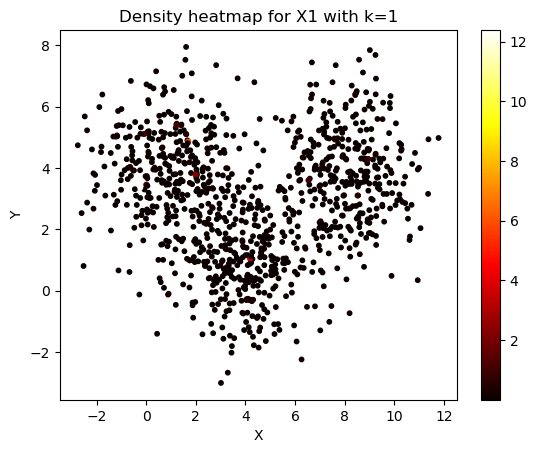

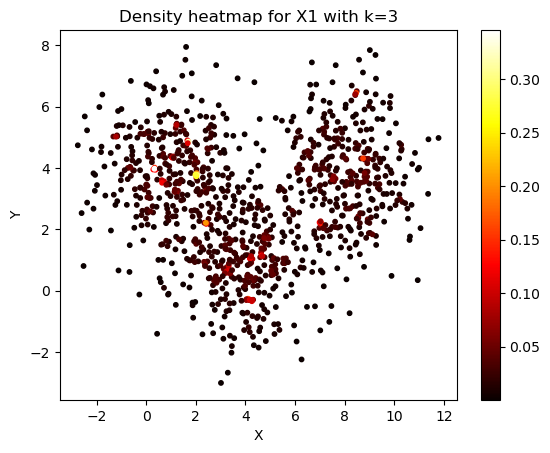

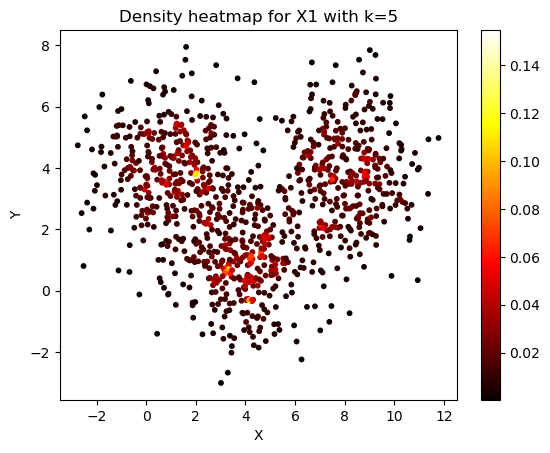

In [27]:
# X1数据集
for k in [1,3,5]:
    densitiesX1= kdensity(np.array(X1), k=k)
    #测试
    #print(densitiesX1)
    #print(len(densitiesX1))
    plt.scatter(X1[:, 0], X1[:, 1], c=densitiesX1, cmap='hot', s=10)
    plt.colorbar()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Density heatmap for X1 with k={}".format(k))
    plt.show()


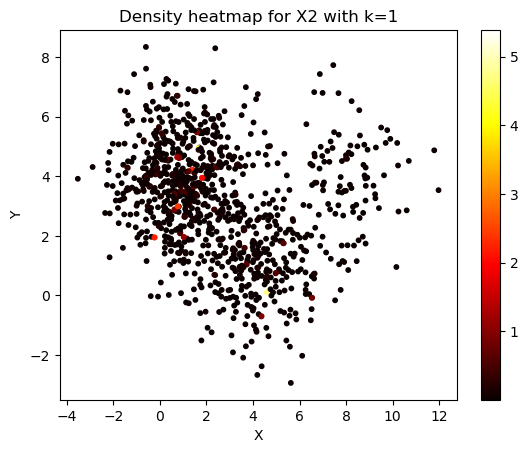

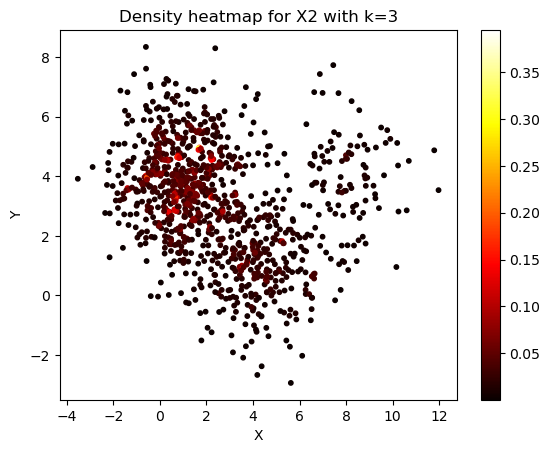

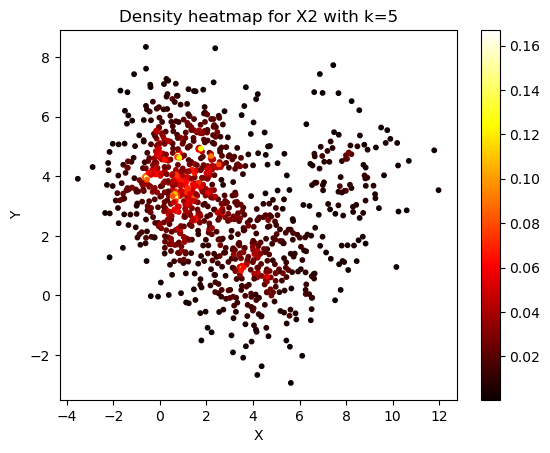

In [28]:
# X2数据集
for k in [1,3,5]:
    densitiesX2= kdensity(np.array(X2), k=k)
    #测试
    #print(densitiesX1)
    #print(len(densitiesX1))
    plt.scatter(X2[:, 0], X2[:, 1], c=densitiesX2, cmap='hot', s=10)
    plt.colorbar()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Density heatmap for X2 with k={}".format(k))
    plt.show()

#### 分析

- 首先可以看到点的分布是和在最开始生成的数据分布是完全一致的（因为绘制点的坐标是不会变的），唯一区别的是点的热力程度不同，因为这里我是对每个点都计算了其密度，其密度与测试点周围的点密集程度正相关。
- 其次而且我们可以发现，随着k的增长，密度都是逐渐变小的，原因是由于k近邻找到的圆面积逐渐变大，导致密度逐渐变小，对于同一张图来讲，亮度越高的地方代表其密度越大，密度越大代表这个地方的点更密集。
- 再者分别我们针对每张图，可以发现，亮度更高的点都集中在我们随机生成数据集时候的均值向量附近，这里先以上图X2数据集上令k=5来说，可以看到占比最大的以（1,4）为均值向量的数据类的点更加亮，这说明这个数据类的数据是更加集中的，这也恰恰印证了其数量占比最大。之后我再以X1数据集上令k=5来说，发现亮度更大的点都集中在三个均值向量处，而且亮度的程度接近，这与三类数据类数量占比均衡密不可分。
- 最后我来分析对于同一个数据集，k递增的情况下，随着k的增大，我们可以发现较于其他点密度更大的点的数据更多了（表现为亮度高的点逐渐变多变集中），而且根据我在上面一条中分析的那样，这些亮度突出的点一般都集中与数据类的均值向量处，这也与数据生成的规则相符。